In [1]:
import pydub
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
f = pydub.AudioSegment.from_mp3('data/3notes_180.mp3')
x = np.array(f.get_array_of_samples()).reshape(-1)
f = pydub.AudioSegment.from_mp3('data/AmPent_1st.mp3')
y = np.array(f.get_array_of_samples()).reshape(-1)

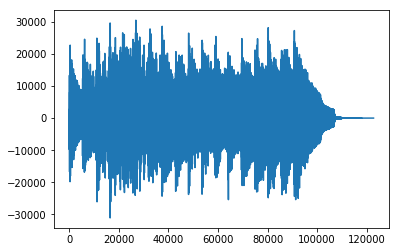

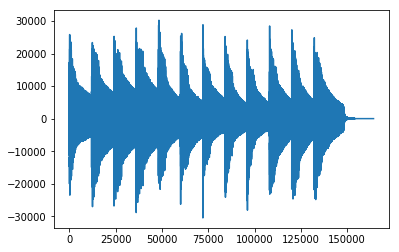

164207

In [3]:
plt.plot(x)
plt.show()
plt.plot(y)
plt.show()

In [9]:
# y(t) = A*sin(2*pi*f*t)
def waves_from_array(arr):
    waves = []  # saved as (A, length of wave)
    prev = 0
    for t in range(1, arr.size):
        if arr[t-1] < 0 <= arr[t] or t == arr.shape[0] - 1:
            r = arr[prev:t]
            prev = t
            # save wave to list (in order)
            amp = max(abs(r))
            waves.append((amp, len(r)))
    return waves

def array_from_waves(w):
    arr = []
    for amp, l in w:
        wav = np.arange(l) / l
        wav = amp * np.sin(2 * np.pi * wav)
        arr.extend(wav)
    return np.array(arr)

def waves_in_range(w, r):
    rsum = np.cumsum([l for _, l in w])
    ii = np.where((rsum < r[1]) & (rsum > r[0]))[0]
    return [w[i] for i in ii]

In [4]:
# 3 notes at 180bpm, 1 every 5334 samples
n = 3
x_waves = waves_from_array(x)
look_for_note = []
scores = []  # difference from ideal in number of samples, in order
l_stack = []
t = 0
prev_t = 0
for a, l in x_waves:
    look_for_note.append((a, prev_t + t)) # amplitude, start time of wave
    t += l
    l_stack.append(l)
    if t > 16000/n: # 1/3 of a second + 2 win_exts
        # notes in recording are played at the start, so assume best position is at beginning of range
        score = max(look_for_note, key=lambda w: w[0])
        c = 1
        while score[1] - prev_t > 16000/(n*2):  # seeing next note
            score = max(look_for_note[:-c], key=lambda w: w[0])
            c += 1
        score = (score[1] - prev_t, score[0]) # start of time wave relative to start of sec/n, amplitude
        look_for_note = look_for_note[-c:]
        if score[1] > 15000:  # filter out maxes from end
            scores.append((score, prev_t + score[0]))
        prev_t += 16000 // n
        t = 0

print(len(scores))  #18
scores

18


[((389, 22729), 389),
 ((780, 24577), 6113),
 ((374, 26096), 11040),
 ((227, 31118), 16226),
 ((0, 26566), 21332),
 ((0, 30500), 26665),
 ((354, 27791), 32352),
 ((-74, 28610), 37257),
 ((-64, 22835), 42600),
 ((-127, 26478), 47870),
 ((38, 23470), 53368),
 ((142, 25431), 58805),
 ((434, 19412), 64430),
 ((-48, 24777), 69281),
 ((905, 24747), 75567),
 ((-103, 28192), 79892),
 ((121, 23867), 85449),
 ((-279, 27281), 90382)]

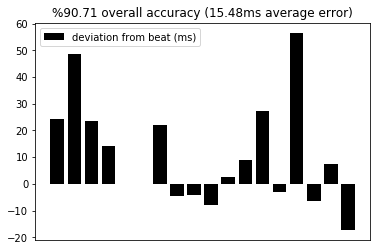

In [5]:
stats = np.array([s[0][0] for s in scores])
ave_dev = np.average(np.abs(stats))
accuracy = (1 - ave_dev/(16000/(n*2)))*100  # 0% accuracy = 16000/(n*2)
ii = range(1, len(stats)+1)
plt.bar(ii, stats/16, color='black', label='deviation from beat (ms)')
plt.xticks([], [])
plt.title('%{:.2f} overall accuracy ({:.2f}ms average error)'.format(accuracy, ave_dev/16))
plt.legend()
plt.show()

126.15168903316265 110.0
138.40502429197772 130.8127826502993
154.6097268897581 146.8323839587038
172.25087148166287 164.813778456435
215.42157313965626 195.99771799087466
230.24424856828483 220.00000000000003
292.8791739305351 261.6255653005987
1147.0705602773096 293.66476791740763
1066.6311182208003 329.62755691287003
478.43870340598943 391.9954359817494
482.4726724462872 440.0000000000001
557.3941821982233 523.2511306011974


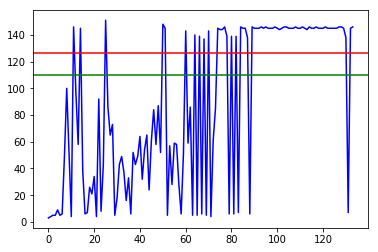

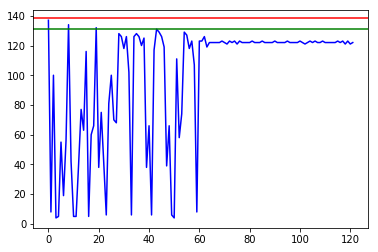

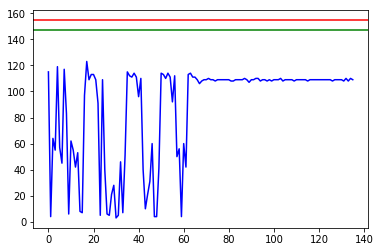

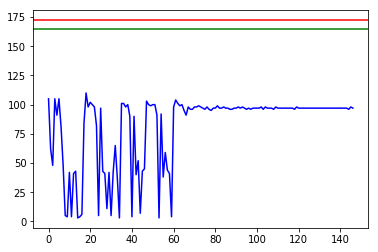

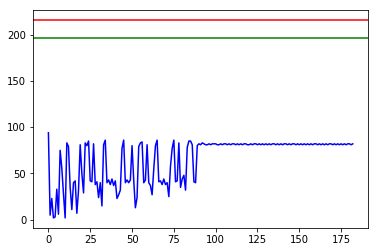

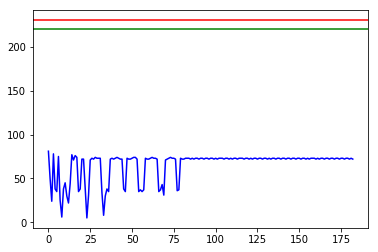

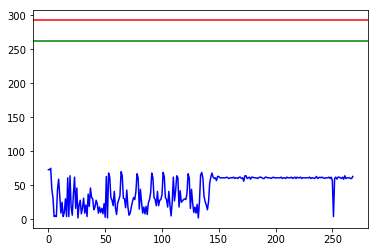

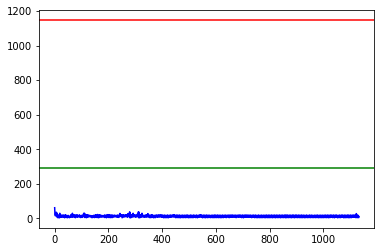

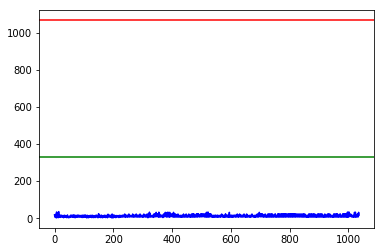

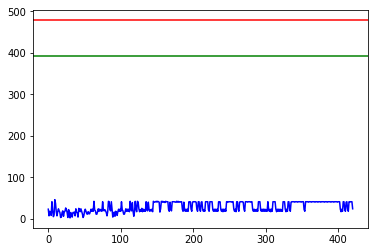

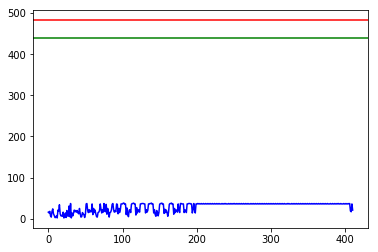

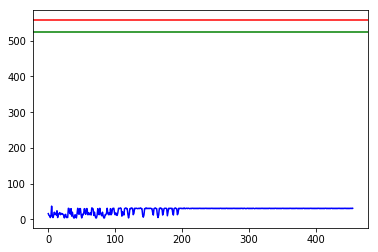

In [10]:
# notes played exactly every 12000 samples
step = 12000
y_waves = waves_from_array(y)
notes = []
def true_pentatonic_freqs(octave=2, position=1, descending=False):
    ratios = [3, 2, 2, 3, 2]
    if descending:
        ratios = ratios[::-1]
    f = 27.5 * (2**octave)
    while position > 1:
        r = ratios.pop(0)
        ratios.append(r)
        f *= 2**(r/12)
        position -= 1
    while True:
        for r in ratios:
            yield f
            f *= 2**(r/12)
tv = true_pentatonic_freqs()
for t in range(0, y.size, step):
    w = waves_in_range(y_waves, (t, t + step))
    if max(a for a, _ in w) > 15000:  # filter out maxes from end
        lens = np.array([l for _, l in w])
        amps = np.array([a for a, _ in w])
        freq = 16000 / np.average(lens, weights=lens)
        true = next(tv)
        print(freq, true)
        plt.plot(lens, color='b')
        plt.axhline(freq, color='r')
        plt.axhline(true, color='g')
        plt.show()
        notes.append(freq)
# notes

In [11]:
def note_range(tf):
    d = 2**(1/12)
    t = (tf + tf*d)/2
    b = (tf + tf/d)/2
    return b, t
# yy = array_from_waves(waves_from_array(y))
yy = y
tv = true_pentatonic_freqs()
for t in range(0, y.size, step):
    if t + step < y.size and max(y[t:t+step]) > 15000:
        wvs = np.fft.fft(yy[t:t+step])[:step//2]
        top = list(np.argsort(wvs))
        true = next(tv)
        print('true:', true)
        ttop = 16000*top.pop()/step
        rank = 1
        r = note_range(true)
        while not r[0] < ttop < r[1]:
            ttop = 16000*top.pop()/step
            rank += 1
        print('rank =', rank, ' freq =', ttop, '\n')
        # print(np.average(top))
        # print(list(reversed(top_5)))

true: 110.0
rank = 1  freq = 110.66666666666667 

true: 130.8127826502993
rank = 4  freq = 129.33333333333334 

true: 146.8323839587038
rank = 5  freq = 146.66666666666666 

true: 164.813778456435
rank = 1  freq = 164.0 

true: 195.99771799087466
rank = 4  freq = 197.33333333333334 

true: 220.00000000000003
rank = 3  freq = 221.33333333333334 

true: 261.6255653005987
rank = 1  freq = 262.6666666666667 

true: 293.66476791740763
rank = 3  freq = 293.3333333333333 

true: 329.62755691287003
rank = 3  freq = 329.3333333333333 

true: 391.9954359817494
rank = 1  freq = 393.3333333333333 

true: 440.0000000000001
rank = 1  freq = 441.3333333333333 

true: 523.2511306011974
rank = 6  freq = 525.3333333333334 



You played an ascending A-minor pentatonic scale in the 4th position!


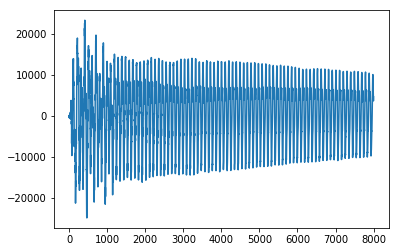

In [36]:
# audio is guaranteed 1 note per 'step' samples
f = pydub.AudioSegment.from_mp3('data/AmPent_4th.mp3')
z = np.array(f.get_array_of_samples()).reshape(-1)
step = 8000
nfs = []
for t in range(0, z.size, step):
    x = z[t:min(t+step,z.size)]
    if max(x) > 15000:  # filter out end
        wvs = np.fft.fft(x)[:len(x)//2]
        nfs.append(16000*np.argsort(wvs)/step)
best_fit = (None, -1)
for octave in range(0, 9):
    for position in range(1, 6):
        for descending in [False, True]:
            tfs = true_pentatonic_freqs(
                octave=octave,
                position=position,
                descending=descending)
            score = 0
            for n in nfs:
                true_note = next(tfs)
                r = note_range(true_note)
                hits = np.where((r[0] < n) & (n < r[1]))[0]
                if hits.size > 0:
                    score += max(hits)
            if score > best_fit[1]:
                best_fit = ((octave, position, descending), score)

result = 'You played a{} A-minor pentatonic scale in the {}{} position!'.format(
    ' descending' if best_fit[0][2] else 'n ascending',
    best_fit[0][1],
    'st' if best_fit[0][1] == 1 else
    'nd' if best_fit[0][1] == 2 else
    'rd' if best_fit[0][1] == 3 else
    'th'
)
print(result)
plt.plot(z[:step])
plt.show()

